In [1]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.integrate import quad
plt.style.use('dark_background')


# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png)  Linear Regression with Bayes
Week 11 | 1.1

### LEARNING OBJECTIVES
*After this lesson, you will be able to:*
- Describe the difference between MAP and expected value
- Implement linear regression with PYMC3
- Calculate the probability of values given Bayesian context


## Setup
We are going to be using PYMC3 today.

[install](https://pymc-devs.github.io/pymc3/notebooks/getting_started.html#Installation)

### Bayes' thereom:

 $$P\left(\;model\;|\;data\;\right) = \frac{P\left(\;data\;|\;model\;\right)P\left(\;model\;\right)}{P(\;data\;)} $$
 
 Today we are going to look at generating the full posterior distribution based on our prior assumptions and data we've observed.


## Probability Density Function (PDF)

Recall, that this is the function that describes the probability for continous random variables.  

If we want to find the probability that the value lies in a certain interval, we integrate the PDF over that interval.

## Example, normal distribution

$$PDF = \sqrt{\frac{1}{2\sigma^2 \pi}}e^{\frac{-1}{2\sigma^2}(x - \mu)^2}$$

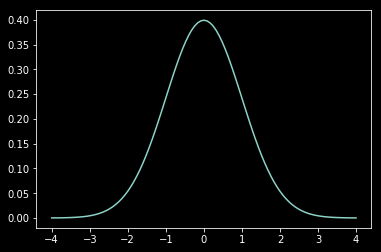

In [2]:
mu = 0
sigma = 1
pdf = lambda x: np.sqrt(1/(2*sigma**2*np.pi))*np.exp((-1/(2*sigma**2))*(x-mu)**2)
X = np.linspace(-4,4,101)
plt.plot(X, [pdf(x) for x in X])

## Calculating the probability of being in a certain interval

E.g., what is the probability that X falls in the range 1 to 2?

In [3]:
quad(pdf,1,2)[0]

0.13590512198327784

## How else could we calculate this probability?

Let's say, for whatever reason, it is hard to integrate the PDF.  What could we do to calculate the probability that X falls in the range 1 to 2?

We could randomly sample from the underlying distribution.   And then find the fraction of observations that lie in the interval 1 to 2.

In [4]:
sample = np.random.randn(300000)
len([i for i in sample if i>1 and i<2]) / len(sample)

0.13548666666666667

In [5]:
quad(pdf,1,2)[0]

0.13590512198327784

## A reminder on random sampling

Recall, that if you take enough samples from an underlying distribution (population), then the mean of the sample will approach the mean of the distribution.

Also, the distribution of the values in our sample will approximate the shape of the PDF.



For example, we have a random variable with mean 165 and standard deviation of 20.  We draw 10,000 random observations from that distribution.

A histogram of this will approximate the PDF

In [6]:
pdf = lambda y:1/np.sqrt(2*np.pi*(20**2))*np.exp(-((y-165)**2)/(2*20**2))

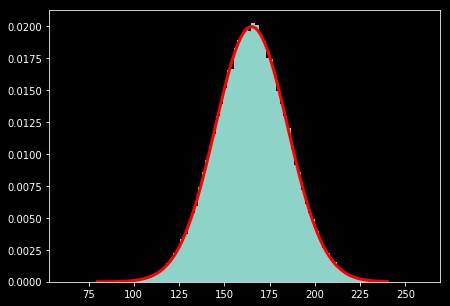

In [7]:
fig, ax = plt.subplots(figsize=(7,5))
samples = np.random.randn(100000)*20+165
ax.hist(samples, normed=True, bins=100)
Xs = np.linspace(80,240,100)
ax.plot(Xs,pdf(Xs), c='r', lw=3);

## Linear Regression

Let's say we have a predictor x and a target y.  

$$y = \beta_0 +\beta_1 *x$$

We use ordinary least squares and calculate the regression line:

$$y = 0 + 2*x$$

If you were asked to make a prediction for the value of y when x = 3, what would you say?

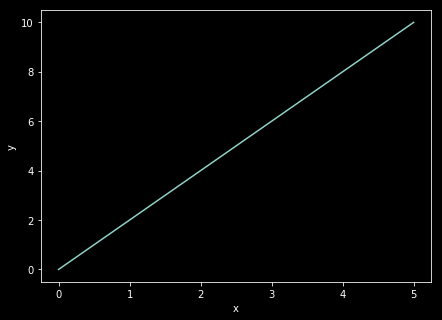

In [8]:
fig, ax = plt.subplots(figsize=(7,5))
plt.plot([0,5], [0,10])
ax.set_xlabel("x")
ax.set_ylabel("y");

## Recall that one of the assumptions of linear regression is that the residuals (errors) are normally distributed with a mean of 0

So what does that mean for our prediction?

In [9]:
beta = 2
sigma = 1
pdf = lambda x, y: np.sqrt(1/(2*sigma**2*np.pi))*np.exp((-1/(2*sigma**2))*(y-beta*x)**2)

X = np.linspace(0,5, 500)
Y = np.linspace(0,10, 500)
X, Y = np.meshgrid(X, Y)
pdf_vec = np.vectorize(pdf)

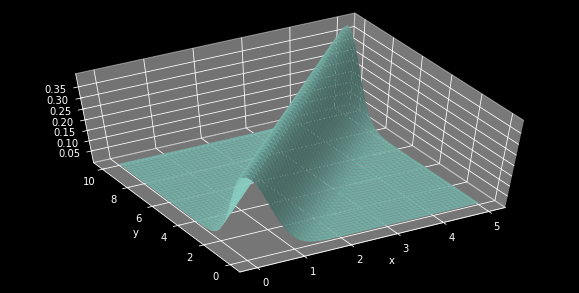

In [10]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,1,1, projection = '3d')
ax1.plot_surface(X, Y, pdf_vec(X, Y))
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.view_init(elev=55, azim=240)
plt.show()

## Back to the normal distribution PDF

$$PDF = \sqrt{\frac{1}{2\sigma^2 \pi}}e^{\frac{-1}{2\sigma^2}(y - \mu)^2}$$

For any given x, there is a distribution of possible y values.  The mean of this distribution is the regression line.

So we can rewrite the above equation as:

$$PDF = \sqrt{\frac{1}{2\sigma^2 \pi}}e^{\frac{-1}{2\sigma^2}(y - (\beta_0 +\beta_1 x))^2}$$

>Before we jump into Bayesian Regression...let's make sure this makes sense

## Linear Regression with Bayes

To start, we going to use simulated data.  

Over many days, we have collected 1000 observations of tide heights from midnight to noon.

In [11]:
np.random.seed(5)
alpha = 3.5
beta = 2
sigma = 0.5
size = 1000
X = np.random.sample(size)*12
y = alpha + beta*np.sin(X) + np.random.randn(size)*sigma

Text(0,0.5,'wave height')

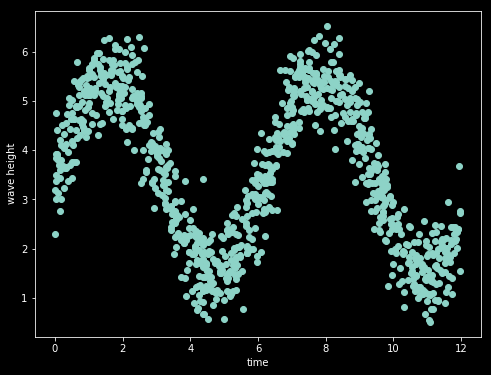

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(X,y)
ax.set_xlabel("time")
ax.set_ylabel('wave height')

## We're going to use pymc3 to find the model parameters 

We believe our regression line is of the form:

$$ y = \alpha + \beta sin(x)$$

where y is the tide height, and t is the time of day.

> How many model parameters are we going to try to solve for?

Actually we're going to look for 3!

We need to find $\alpha$ and $\beta$, but also $\sigma$ which describes the dispersion of tide heights around the mean at a given time.

For simplicity, we are going to assume that $\sigma$ does not vary with time.

Since we're taking the Bayesian approach, we need prior distributions for all our model parameters.  What could we use?

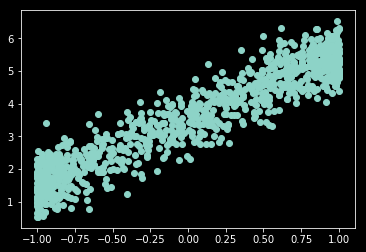

In [13]:
plt.scatter(np.sin(X),y)

In [14]:
from pymc3 import Model, Normal, HalfNormal
basic_model = Model()
with basic_model:
    alpha = Normal('alpha', mu=0, sd=10)
    beta = Normal('beta', mu=0, sd=10, shape=1)
    sigma = HalfNormal('sigma', sd=1)
    mu = alpha + beta*np.sin(X)
    Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=y)

ModuleNotFoundError: No module named 'pymc3'

$$P\left(\;model\;|\;data\;\right) = \frac{P\left(\;data\;|\;model\;\right)P\left(\;model\;\right)}{P(\;data\;)} $$
 

Let's say we want a quick and easy (ish) point estimate for our model parameters, that takes into account our uncertainty.

We could find the MAP (maximum a posteriori).  This is essentially the mode of our posterior distribution!

> Check: in what way is this different to the maximum likelihood?

In [34]:
from pymc3 import find_MAP
map_estimate = find_MAP(model=basic_model)
print(map_estimate)

logp = -764.56, ||grad|| = 271.67: 100%|██████████| 30/30 [00:00<00:00, 1299.14it/s]   

{'alpha': array(3.5063257205033898), 'beta': array([ 2.0093051]), 'sigma_log__': array(-0.6858303459345094), 'sigma': array(0.5036718340326303)}


Let's see what we get with sklearn

In [36]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(np.sin(X).reshape(-1,1), y)
print (lr.intercept_)
print (lr.coef_)

3.50633443733
[ 2.00931465]


## Let's plot the MAP regression line


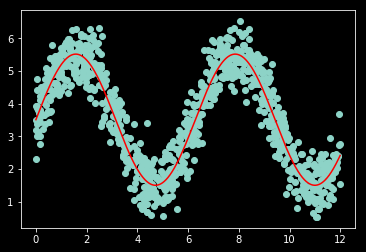

In [37]:
alpha_est = np.float(map_estimate['alpha'])
beta_est = np.float(map_estimate['beta'][0])
reg = np.vectorize(lambda x:  alpha_est + beta_est*np.sin(x))
x_vals = np.arange(0,12, 0.01)
plt.scatter(X,y)
plt.plot(x_vals, reg(x_vals), c='r');

What might be the problem with maximum likelihood / MAP?

Why might we not want to use it?

Since, with Bayes, we're concerned with distributions of belief, let's see what the posterior distribution looks like for each of our three model parameters
- $\alpha$
- $\beta$
- $\sigma$

To do this, we randomly sample from the posterior distribution

In [38]:
from pymc3 import NUTS, sample
from scipy import optimize

with basic_model:
    trace = sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:02<00:00, 982.85it/s]


## We can examine the distributions of each model parameter

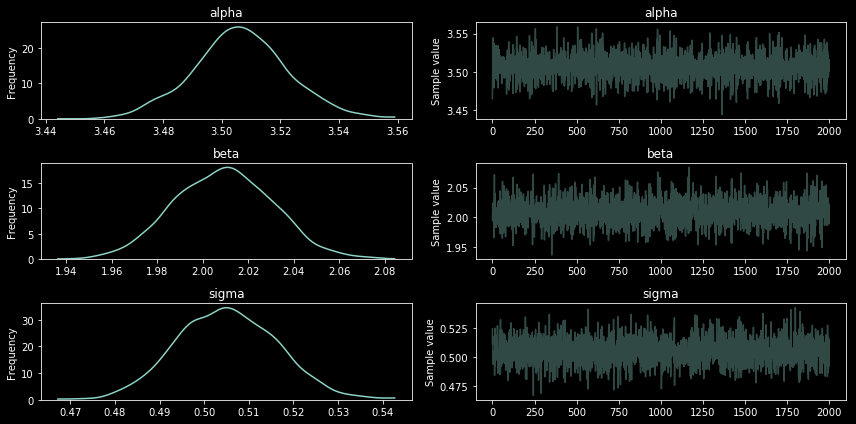

In [39]:
from pymc3 import traceplot
traceplot(trace);

How should we interpret them?

Why is seeing the full distribution useful?

## Let's say we want to a predition for wave heights at 6am

We can generate a probability density function for the heights at that time.  We also want to take into account that we actually don't know what our model parameters are... so we do this by taking the average of all our model parameter estimates

In [42]:
draws = list(zip(trace['alpha'], trace['beta'][:,0], trace['sigma']))

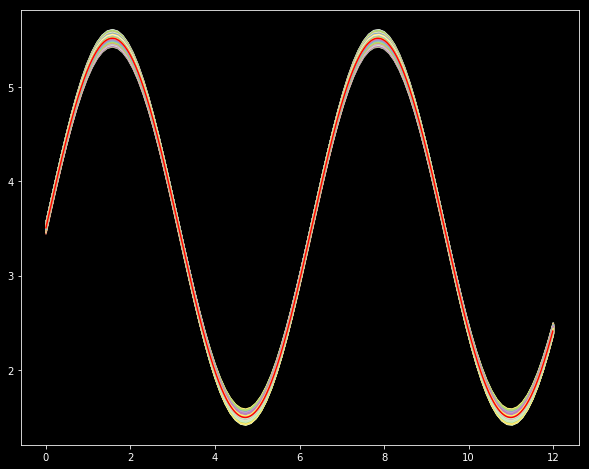

In [86]:
fig, ax = plt.subplots(figsize=(10,8))
reglin = lambda a, b: lambda x: a + b*np.sin(x)
Xs = np.linspace(0,12,100)
# plt.scatter(X,y)
for i in range(2000):
    plt.plot(Xs, reglin(draws[i][0], draws[i][1])(Xs))
plt.plot(x_vals, reg(x_vals), c='r');

In [83]:
f = lambda y, x: lambda d: \
1 / (np.sqrt(2*(d[2]**2)*np.pi))*np.exp(((y-d[0]-d[1]*np.sin(x))**2) / \
                                        (-2*d[2]**2))

In [84]:
def func(y,x):
    N = len(draws)
    return 1/float(N)*sum([f(y,x)(d) for d in draws])

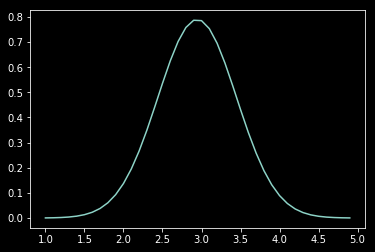

In [85]:
predictiveDist = np.vectorize(func)
y = np.arange(1,5, 0.1)
plt.plot(y,predictiveDist(y, 6))

If we needed a single point estimate, we could generate one (maximum / mean).

But the key is that we have access to the full distribution which incorporates our uncertainty about the likely model parameters.

## Further analysis

We're asked to calculate the probability that wave height exceeds 6.5 feet at any time.

Based on the regression line, what would you say?

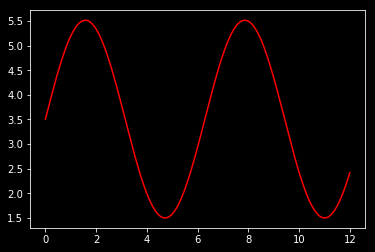

In [48]:
reg = np.vectorize(lambda x:  alpha_est + beta_est*np.sin(x))
x_vals = np.arange(0,12, 0.01)
plt.plot(x_vals, reg(x_vals), c='r');

We want to incorporate both that we know that the wave heights at a given time are normally distributed around their mean, and also that we actually don't really know what that mean is (and we don't know the variance of the distribution).

Bayes allows us to incorporate that uncertainty by using the full posterior distribution.

In [50]:
# randomly sample from posterior, and generate random heights
heights = []
for i in range(len(trace)):
    num = np.random.randint(0,len(trace)-1)
    a = trace['alpha'][num]
    b = trace['beta'][num]
    s = trace['sigma'][num]
    #randomly sample a time
    x_i = np.random.rand()*12
    mu_i = a + b*np.sin(x_i)
    #randomly sample a height
    heights.append(np.random.normal(mu_i, s, 1)[0])
    

Now we have 2000 randomly generated heights across the 12 hours.

Our estimated heights incorporate our uncertainty about $\mu$ and $\sigma$ at any time

In [51]:
# take the proportion of heights above 6.5
len([i for i in heights if i >6.5])/len(heights)

0.003

# With real data now - Ames Housing Data


In [52]:
df = pd.read_csv("ames.csv")
df = df[['SalePrice', 'Yr.Sold', 'Lot.Area', 'Lot.Frontage']]
df.dropna(inplace=True)
from sklearn.preprocessing import StandardScaler
df = StandardScaler().fit_transform(df)
df = pd.DataFrame(df, columns=['SalePrice', 'Yr.Sold', 'Lot.Area', 'Lot.Frontage'])

## Let's first generate our coefficients with sklearn

In [54]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
X = df.iloc[:,1:]
y = df['SalePrice']
lr.fit(X,y)
print (lr.intercept_)
print (lr.coef_)

1.18171025756e-15
[-0.02146954  0.1915879   0.26302618]


## Now let's use PYMC3 to find the MAP

In [55]:
basic_model = Model()

with basic_model:

    alpha = Normal('alpha', mu=0, sd=10)
    beta = Normal('beta', mu=0, sd=10, shape=3)
    sigma = HalfNormal('sigma', sd=1)

    mu = alpha + beta[0]*df['Yr.Sold'] + \
          beta[1]*df['Lot.Area'] + beta[2]*df['Lot.Frontage']
    Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=y)

In [56]:
map_estimate = find_MAP(model=basic_model)
print(map_estimate)

logp = -3,621.1, ||grad|| = 2,311: 100%|██████████| 11/11 [00:00<00:00, 1092.68it/s]

{'alpha': array(1.2145647190165394e-15), 'beta': array([-0.02147375,  0.19158555,  0.26302561]), 'sigma_log__': array(-0.08505106687354515), 'sigma': array(0.9184653800484197)}


## Now let's find the full posterior distribution

In [57]:
with basic_model:
    trace = sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:06<00:00, 395.84it/s]


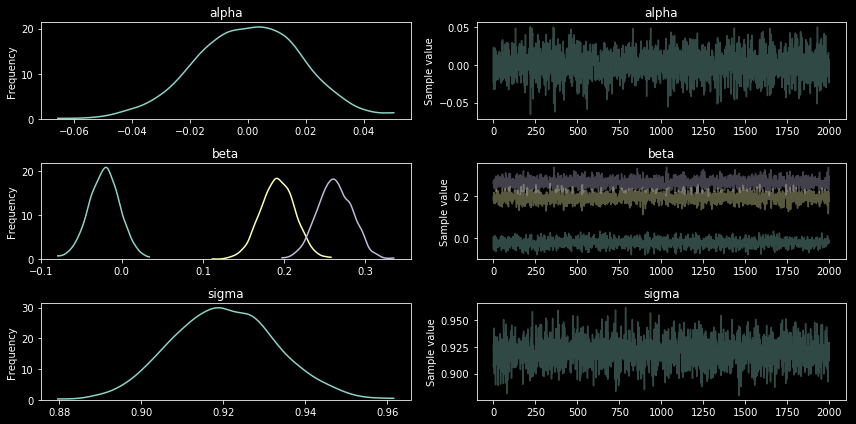

In [58]:
traceplot(trace);

>What can we learn from these plots?


## Conclusion (5 min)


We looked at how to generate a full distribution of our posterior, that incorporates our prior belief and the data we've seen.  We also discussed that we can generate point estimates from these distributions.